In [1]:
# Configs

label_name = "math"
embedding_type = "perf" # time or perf

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = pd.read_csv(f"../../dataset/{embedding_type}/small_{label_name}_dataset.csv")
dataset = pd.get_dummies(dataset)

# dataset = dataset.filter(regex=("(branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_POLYNOMIAL|context-switches_FEATURE_TYPE_LOGLOG_POLYNOMIAL|context-switches_FEATURE_TYPE_LOG_POLYNOMIAL|cpu-migrations_FEATURE_TYPE_LOGLOG_POLYNOMIAL|cpu-migrations_FEATURE_TYPE_LOG_POLYNOMIAL|cycles_FEATURE_TYPE_LOGLOG_POLYNOMIAL|instructions_FEATURE_TYPE_LOGLOG_POLYNOMIAL|instructions_FEATURE_TYPE_POLYNOMIAL|page-faults_FEATURE_TYPE_LOGLOG_POLYNOMIAL|stalled-cycles-frontend_FEATURE_TYPE_LOGLOG_POLYNOMIAL|task-clock_FEATURE_TYPE_LOGLOG_POLYNOMIAL)"))
# dataset = dataset.filter(regex=("(branch-misses_INTERCEPT|page-faults_INTERCEPT|stalled-cycles-frontend_INTERCEPT|branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_POLYNOMIAL|instructions_FEATURE_TYPE_LOGLOG_POLYNOMIAL|instructions_FEATURE_TYPE_POLYNOMIAL|page-faults_FEATURE_TYPE_LOGLOG_POLYNOMIAL|stalled-cycles-frontend_FEATURE_TYPE_FRACTIONAL_POWER|stalled-cycles-frontend_FEATURE_TYPE_LOGLOG_POLYNOMIAL')"))
dataset = dataset.filter(regex=("(branch-misses_INTERCEPT|page-faults_INTERCEPT|branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_POLYNOMIAL|instructions_FEATURE_TYPE_POLYNOMIAL|stalled-cycles-frontend_FEATURE_TYPE_FRACTIONAL_POWER)"))
# dataset = dataset.filter(regex=(".*"))

dataset = dataset/(0.00001 + dataset.max())
dataset.head()

,branch-misses_INTERCEPT,page-faults_INTERCEPT,branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL,branches_FEATURE_TYPE_POLYNOMIAL,instructions_FEATURE_TYPE_POLYNOMIAL,stalled-cycles-frontend_FEATURE_TYPE_FRACTIONAL_POWER
0,0.896508,0.464133,0.0,0.99999,0.99999,0.00000
1,0.905681,0.465236,0.0,0.00000,0.00000,0.99999
2,0.912733,0.466022,0.0,0.99999,0.99999,0.00000
3,0.909931,0.468263,0.0,0.99999,0.99999,0.00000
4,0.906618,0.463599,0.0,0.99999,0.99999,0.00000


In [4]:
labels = pd.read_csv(f"../../dataset/{embedding_type}/small_{label_name}_dataset.csv").filter(regex=("label"))
labels.head()

,label
0,0
1,0
2,0
3,0
4,0


In [5]:
data = dataset.copy().to_numpy() 
target = labels.copy().pop('label').to_numpy() 

In [6]:
from minisom import MiniSom    

# Initialization and training
n_neurons = 6
m_neurons = 6
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1, learning_rate=.5, random_seed=42, neighborhood_function='gaussian')

som.pca_weights_init(data)

To understand how the training evolves we can plot the quantization and topographic error of the SOM at each step. This is particularly important when estimating the number of iterations to run:

In [7]:
max_iter = 1000000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

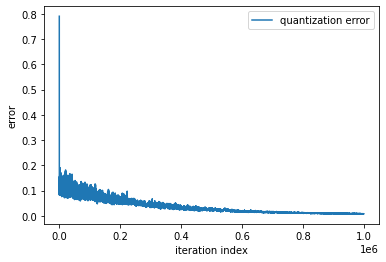

In [8]:
plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

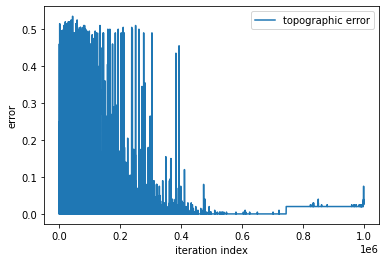

In [9]:
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [10]:
som.train(data, max_iter, verbose=True)

 [    1302 / 1000000 ]   0% - 0:02:34 left 

 [    2287 / 1000000 ]   0% - 0:02:56 left 

 [    2910 / 1000000 ]   0% - 0:03:28 left 

 [    3835 / 1000000 ]   0% - 0:03:22 left 

 [    4779 / 1000000 ]   0% - 0:03:33 left 

 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.008016804477944882


To have an overview of how the samples are distributed across the map a scatter chart can be used where each dot represents the coordinates of the winning neuron. A random offset is added to avoid overlaps between points within the same cell


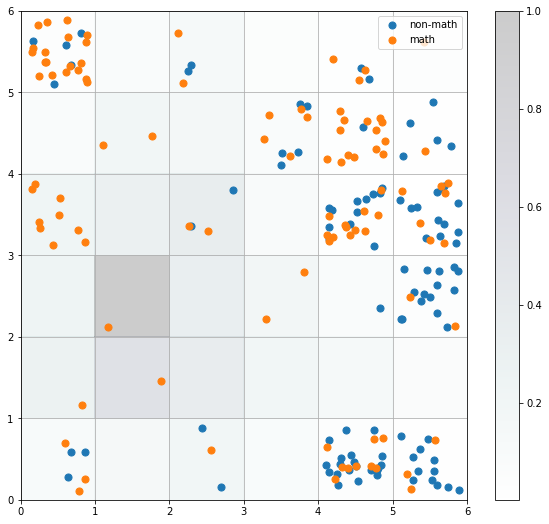

In [11]:
colors = ['C0', 'C1']

label_names = {0:'non-math', 1:'math'}

w_x, w_y = zip(*[som.winner(d) for d in data])
w_x=np.array(w_x)
w_y=np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.savefig('som_seed.png')
plt.show()

To have an idea of which neurons of the map are activated more often we can create another pseudocolor plot that reflects the activation frequencies:

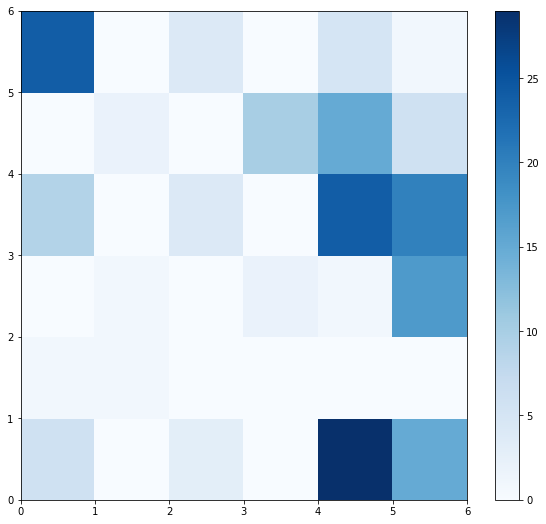

In [12]:
plt.figure(figsize=(10, 9))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

When dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron:

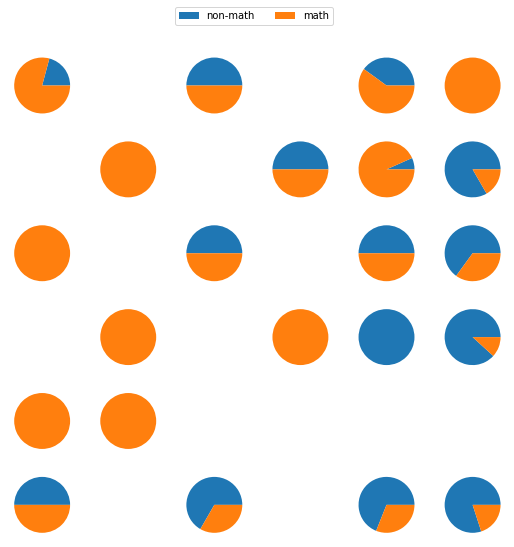

In [13]:
labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.savefig('som_seed_pies.png')
plt.show()